Passo 2:

In [8]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado


def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtenha o grau 'r' do gerador.
    #    Lembre-se que um gerador de n bits representa um polinômio de grau n-1.
    r = len(gerador_bits) - 1

    # 2. Crie T(x)=  M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Implemente o loop de divisão.
    #    Percorra os bit original da mensagem (em uma janela), da esquerda para a direita.
    for i in range(len(dados_bits)):
        # Se o bit mais significativo da 'janela' atual for '1', realize o XOR.
        # - considere a janela atual como os próximos r+1 bits. (para pode dividir o por G(x))
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + r + 1
            janela_atual = "".join(mensagem_aumentada[inicio : fim]) # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualize a mensagem com o resultado do XOR.
            # - Substitua os bits correspondentes na mensagem pela saída do XOR,
#          ignorando o primeiro bit (que já foi processado).
            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

Caso de teste do Passo 2:

de acordo com os slides, para:


dados_teste = "1101011111"  # M(x)

gerador_teste = "10011" # G(x)

CRC esperado = "0010"

Quadro final para transmissão: "11010111110010" # T(x)



In [9]:
# Exemplo de uso para validação
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"    # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")
print(f"Quadro transmitido T(x): {dados_teste + crc_calculado}")
# Quadro T(x) a ser transmitido: dados_teste + crc_calculado

Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 0010
Quadro transmitido T(x): 11010111110010


Passo 3:

In [10]:
pip install crc

In [11]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16

# --- Insira sua função calcular_crc_manual e xor_bits aqui ---
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado


def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    r = len(gerador_bits) - 1

    mensagem_aumentada = list(dados_bits + '0' * r)

    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + r + 1
            janela_atual = "".join(mensagem_aumentada[inicio : fim]) # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    resto = "".join(mensagem_aumentada[-r:])
    return resto

 # --- Fim das funções calcular_crc_manual e xor_bits do passo 2 ---

 # Usando um padrão de 16 bits como referência
calculator_lib = Calculator(Crc16.MODBUS)

# Tamanhos de mensagem para teste (em bytes)
tamanhos_bytes = [1500, 3000 , 6000 , 16000]

resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando para mensagem de {tamanho} bytes...")
    # Gere uma mensagem aleatória de bits
    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    # Medição da nossa Implementação
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101") # G(x) do CRC-16/MODBUS

    end_time = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_manual = end_time - start_time

    # Medição da Biblioteca
    tracemalloc.start()
    start_time = time.perf_counter()

    crc_lib = calculator_lib.checksum(mensagem_bytes)

    end_time = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_lib = end_time - start_time

    # Armazene os resultados
    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024, # em KiB
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024 # em KiB
    })

print("--- Resultados Finais ---")
print(resultados)

Analisando para mensagem de 1500 bytes...
Analisando para mensagem de 3000 bytes...
Analisando para mensagem de 6000 bytes...
Analisando para mensagem de 16000 bytes...
--- Resultados Finais ---
[{'tamanho': 1500, 'tempo_manual': 0.27000290199998744, 'mem_pico_manual': 105.7509765625, 'tempo_lib': 0.09735407300001953, 'mem_pico_lib': 1.21875}, {'tamanho': 3000, 'tempo_manual': 0.5381719260000182, 'mem_pico_manual': 211.2197265625, 'tempo_lib': 0.15973245200007113, 'mem_pico_lib': 1.21875}, {'tamanho': 6000, 'tempo_manual': 1.0837296590000278, 'mem_pico_manual': 422.1572265625, 'tempo_lib': 0.3378834799999595, 'mem_pico_lib': 1.21875}, {'tamanho': 16000, 'tempo_manual': 3.9505608130000383, 'mem_pico_manual': 1125.2822265625, 'tempo_lib': 0.8855447849999791, 'mem_pico_lib': 1.21875}]


Gráficos:

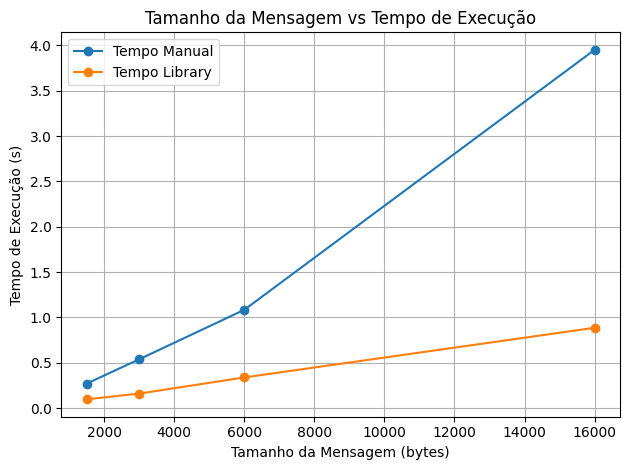

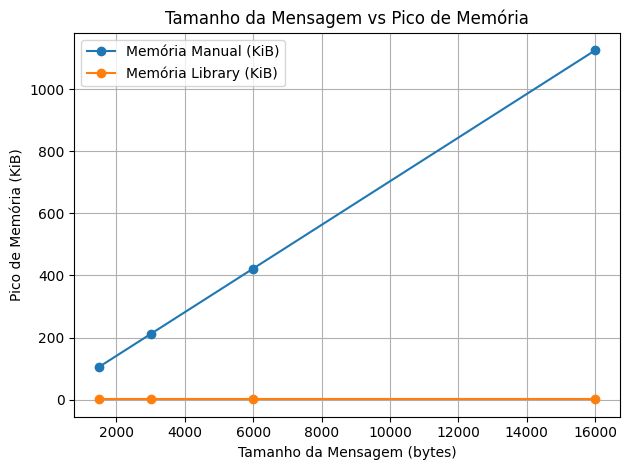

In [12]:
import matplotlib.pyplot as plt


tamanhos = [r["tamanho"] for r in resultados]

tempo_manual = [r["tempo_manual"] for r in resultados]
tempo_lib = [r["tempo_lib"] for r in resultados]

mem_manual = [r["mem_pico_manual"] for r in resultados]
mem_lib = [r["mem_pico_lib"] for r in resultados]

# GRÁFICO 1 - TEMPO
plt.plot(tamanhos, tempo_manual, marker='o', label="Tempo Manual")
plt.plot(tamanhos, tempo_lib, marker='o', label="Tempo Library")
plt.xlabel("Tamanho da Mensagem (bytes)")
plt.ylabel("Tempo de Execução (s)")
plt.title("Tamanho da Mensagem vs Tempo de Execução")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# GRÁFICO 2 - MEMÓRIA
plt.plot(tamanhos, mem_manual, marker='o', label="Memória Manual (KiB)")
plt.plot(tamanhos, mem_lib, marker='o', label="Memória Library (KiB)")
plt.xlabel("Tamanho da Mensagem (bytes)")
plt.ylabel("Pico de Memória (KiB)")
plt.title("Tamanho da Mensagem vs Pico de Memória")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##Parte4:

###4.1:

In [17]:
#Andre Tharssys Marques Soares - 123110543
mensagem_base_andre = "0110000101101110011001000111001001100101001000000111010001101000011000010111001001110011011100110111100101110011001000000110110101100001011100100111000101110101011001010111001100100000011100110110111101100001011100100110010101110011"
gerador_andre = "10001000000100001" #matricula com final 3
crc_andre = calcular_crc_manual(mensagem_base_andre, gerador_andre)

print(f'Variável      | Valor')
print("________________________\n")
print(f'Mensagem      | {mensagem_base_andre + crc_andre}')
print(f'Mensagem_Base | {mensagem_base_andre}')
print(f'CRC           | {crc_andre}')

Variável      | Valor
________________________

Mensagem      | 01100001011011100110010001110010011001010010000001110100011010000110000101110010011100110111001101111001011100110010000001101101011000010111001001110001011101010110010101110011001000000111001101101111011000010111001001100101011100110011010100100110
Mensagem_Base | 0110000101101110011001000111001001100101001000000111010001101000011000010111001001110011011100110111100101110011001000000110110101100001011100100111000101110101011001010111001100100000011100110110111101100001011100100110010101110011
CRC           | 0011010100100110


In [18]:
#Vinícius Gabriel Laureano - 123111119
mensagem_base_vinicius = "01010110011010010110111011101101011000110110100101110101011100110010000001000111011000010110001001110010011010010110010101101100001000000100110001100001011101010111001001100101011000010110111001101111"
gerador_vinicius = "10001000000100001" #matricula com final 9
crc_vinicius = calcular_crc_manual(mensagem_base_vinicius, gerador_vinicius)

print(f'Variável      | Valor')
print("________________________\n")
print(f'Mensagem      | {mensagem_base_vinicius + crc_vinicius}')
print(f'Mensagem_Base | {mensagem_base_vinicius}')
print(f'CRC           | {crc_vinicius}')

Variável      | Valor
________________________

Mensagem      | 010101100110100101101110111011010110001101101001011101010111001100100000010001110110000101100010011100100110100101100101011011000010000001001100011000010111010101110010011001010110000101101110011011110001001110011000
Mensagem_Base | 01010110011010010110111011101101011000110110100101110101011100110010000001000111011000010110001001110010011010010110010101101100001000000100110001100001011101010111001001100101011000010110111001101111
CRC           | 0001001110011000


In [19]:
#Telmano Leite Japiassú Neto - 123110782
mensagem_base_telmano = "010101000110010101101100011011010110000101101110011011110010000001001100011001010110100101110100011001010010000001001010011000010111000001101001011000010111001101110011111110101010000001001110011001010111010001101111"
gerador_telmano = "11000000000000101" #matricula com final 2
crc_telmano = calcular_crc_manual(mensagem_base_telmano, gerador_telmano)

print(f'Variável      | Valor')
print("________________________\n")
print(f'Mensagem      | {mensagem_base_telmano + crc_telmano}')
print(f'Mensagem_Base | {mensagem_base_telmano}')
print(f'CRC           | {crc_telmano}')

Variável      | Valor
________________________

Mensagem      | 0101010001100101011011000110110101100001011011100110111100100000010011000110010101101001011101000110010100100000010010100110000101110000011010010110000101110011011100111111101010100000010011100110010101110100011011110010010001000110
Mensagem_Base | 010101000110010101101100011011010110000101101110011011110010000001001100011001010110100101110100011001010010000001001010011000010111000001101001011000010111001101110011111110101010000001001110011001010111010001101111
CRC           | 0010010001000110


In [22]:
#Adriano Porto Andrade Junior - 123110597
mensagem_base_adriano = "01000001011001000111001001101001011000010110111001101111"
gerador_adriano = "10011000000010001" #matricula com final 7
crc_adriano = calcular_crc_manual(mensagem_base_adriano, gerador_adriano)

print(f'Variável      | Valor')
print("________________________\n")
print(f'Mensagem      | {mensagem_base_adriano + crc_adriano}')
print(f'Mensagem_Base | {mensagem_base_adriano}')
print(f'CRC           | {crc_adriano}')

Variável      | Valor
________________________

Mensagem      | 010000010110010001110010011010010110000101101110011011111010111000000101
Mensagem_Base | 01000001011001000111001001101001011000010110111001101111
CRC           | 1010111000000101


####4.2:

In [20]:
import random

calculator_lib = Calculator(Crc16.MODBUS)

padroes_erros = [
    "11000000000000101", #Gerador para matricula com final 0,1,2
    "10001000000100001", #Gerador para matricula com final 3,4,5,8,9
    "10011000000010001", #Gerador para matricula com final 6,7
    "1011010010110",
    "11100010101",
    "100111000111",
    "1010000110101",
    "110101100001",
    "1110010100111",
    "10000011101001"
]

def bits_to_bytes(bits: str) -> bytes:
    return int(bits, 2).to_bytes(len(bits) // 8, byteorder="big")

def aplicar_erro(quadro, padrao, pos):
    pos-=1
    quadro = list(quadro)
    for i in range(len(padrao)):
        if padrao[i] == quadro[pos+i]: quadro[pos+i] = "0"
        else: quadro[pos+i] = "1"
    return "".join(quadro)

def caca_dos_erros(dados, gerador):
  #print("Iniciando Caça dos Erros")

  r = len(gerador) - 1

  crc_manual = calcular_crc_manual(dados, gerador)
  quadro = dados + crc_manual

  #print(f'Quadro        | {quadro}')
  #print(f'Mensagem_Base | {dados}')
  #print(f'Gerador       | {gerador}')
  #print(f'CRC           | {crc_manual}')

  resultados = []

  for i in range(len(padroes_erros)):
        #print(f"Teste {i+1}")
        padrao_erro = padroes_erros[i]
        pos = random.randint(0, len(quadro) - len(padrao_erro))

        #print(f"Padrão de erro: {padrao_erro}")
        #print(f"Posição do inico dos bits trocados: {pos}")

        quadro_corr = aplicar_erro(quadro, padrao_erro, pos)
        #print(f"Quadro Corrompido: {quadro_corr}")

        crc_manual = calcular_crc_manual(quadro_corr, gerador)

        quadro_corr_bytes = bits_to_bytes(quadro_corr)

        crc_lib = calculator_lib.checksum(quadro_corr_bytes)

        detectou_manual = (crc_manual != "0" * r)
        detectou_lib = (crc_lib != 0)

        #print(f"CRC manual: {crc_manual}")
        #print(f"CRC lib:    {crc_lib}")
        #print(f"Detectou (manual)? {detectou_manual}")
        #print(f"Detectou (lib)?    {detectou_lib}\n")

        resultados.append({
            "padrao": padrao_erro,
            "pos": pos,
            "crc_manual": crc_manual,
            "crc_lib": crc_lib,
            "detectou_manual": detectou_manual,
            "detectou_lib": detectou_lib
        })
  return resultados

In [23]:
dados_grupo = [["André", mensagem_base_andre, gerador_andre],
               ["Telmano", mensagem_base_telmano, gerador_telmano],
               ["Vinicius", mensagem_base_vinicius, gerador_vinicius],
               ["Adriano", mensagem_base_adriano, gerador_adriano]
               ]

for j in range(len(dados_grupo)):
  print(f"Relatório do aluno: {dados_grupo[j][0]}")
  print(f"Mensagem: {dados_grupo[j][1]}")
  print(f"Gerador: {dados_grupo[j][2]}\n")

  results = caca_dos_erros(dados_grupo[j][1], dados_grupo[j][2])

  print(f"Testes em que foi detectado os erros inseridos\n")
  for r in results:
    if r['detectou_manual'] and r['detectou_lib']:
      print(f"Padrão de erro: {r['padrao']}")
      print(f"Posição de inicio da sequencia de erros no quadro: {r['pos']}")
      print(f"CRC da função manual: {r['crc_manual']}")
      print(f"CRC da função da biblioteca: {r['crc_lib']}\n")

  print(f"Testes em que não foi detectado os erros inseridos\n")
  for r in results:
    if not(r['detectou_manual']):
      print(f"Função Manual não conseguiu detectar o erro nesse caso:\n")
      print(f"Padrão de erro: {r['padrao']}")
      print(f"Posição de inicio da sequencia de erros no quadro: {r['pos']}")
      print(f"CRC da função manual: {r['crc_manual']}")
      print(f"CRC da função da biblioteca: {r['crc_lib']}\n")
    elif not(r['detectou_lib']):
      print(f"Função da Bbiblioteca não conseguiu detectar o erro nesse caso:\n")
      print(f"Padrão de erro: {r['padrao']}")
      print(f"Posição de inicio da sequencia de erros no quadro: {r['pos']}")
      print(f"CRC da função manual: {r['crc_manual']}")
      print(f"CRC da função da biblioteca: {r['crc_lib']}\n")



Relatório do aluno: André
Mensagem: 0110000101101110011001000111001001100101001000000111010001101000011000010111001001110011011100110111100101110011001000000110110101100001011100100111000101110101011001010111001100100000011100110110111101100001011100100110010101110011
Gerador: 10001000000100001

Testes em que foi detectado os erros inseridos

Padrão de erro: 11000000000000101
Posição de inicio da sequencia de erros no quadro: 139
CRC da função manual: 1001111100111001
CRC da função da biblioteca: 14755

Padrão de erro: 10011000000010001
Posição de inicio da sequencia de erros no quadro: 147
CRC da função manual: 0000111010010011
CRC da função da biblioteca: 26932

Padrão de erro: 1011010010110
Posição de inicio da sequencia de erros no quadro: 165
CRC da função manual: 0101001111101010
CRC da função da biblioteca: 56646

Padrão de erro: 11100010101
Posição de inicio da sequencia de erros no quadro: 120
CRC da função manual: 1001011001000100
CRC da função da biblioteca: 27538

Padrão de